In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
#from pandas.plotting import autocorrelation_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import DBSCAN
from scipy.stats import itemfreq
from IPython.core.display import display, HTML
from pandas import Series
from sklearn import manifold

%pylab inline

plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = '14'

display(HTML("<style>.container { width:98% !important; }</style>"))

C:\Users\Francesca\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

# Preprocessing

Divisione in Anni

In [3]:
years_groups = series.groupby(pd.Grouper(freq='A'));
giorni = []
for name, i in years_groups:
    #print(len(i.values))
    giorni.append(len(i.values))

#print(sum(giorni)/len(giorni)) #media giorni per anno


Offset Transformation e Amplitude Scaling

In [4]:
mod_series = []
years_list = []
for name, group in years_groups:
    year_values = pd.Series((group.values - group.values.mean())/group.values.std()).rolling(window=4, min_periods=1).mean()
    year_values = year_values.dropna()
    year_values = year_values.reset_index(drop=True)
    mod_series.append(year_values)
    years_list.append(name.year)

#eliminazione ultimo anno (2018) perché incompleto
years_list = years_list[0:(len(years_list)-1)]
mod_series = mod_series[0:(len(mod_series)-1)]

# DTW Sakoe-Chiba

In [5]:
def dtw_band(x, y, dist, band=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences with Sakoe-Chiba band.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int band: size of Sakow-Chiba band (default=inf)

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    # Effect of bands: cells farther than "band" from diagonal have "inf" cost
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(i-j)<band else inf
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


def distance(x,y):
    return abs(x-y)

In [6]:
dd1 = [ [ ( dtw_band(mod_series[x],mod_series[y],distance, 30)[0] \
           if y > x else -1)  \
         for y in range(len(mod_series)) ] 
       for x in range(len(mod_series)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(mod_series)) ] for x in range(len(mod_series)) ]
# Finally, the diagonal
for i in range(len(mod_series)):
    dd2[i][i] = 0.0

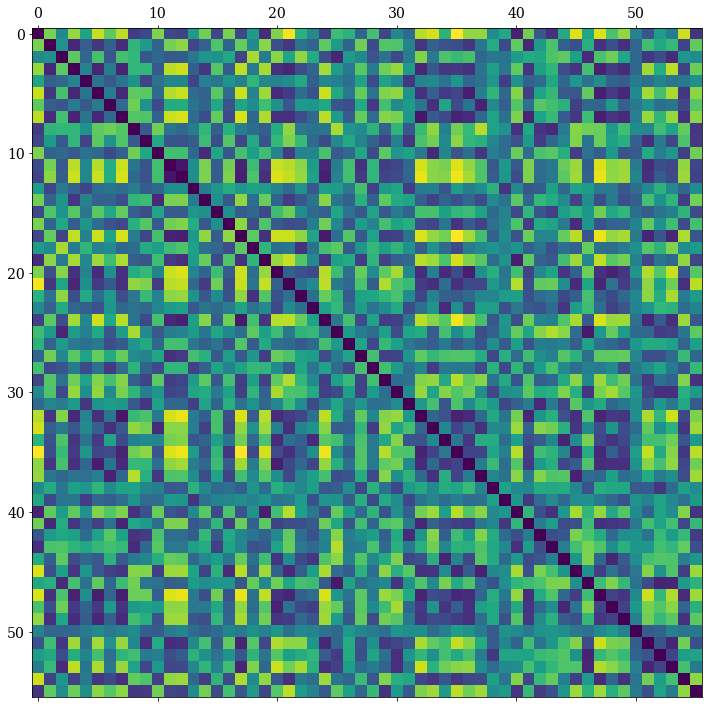

In [7]:
rcParams['figure.figsize'] = 24, 12
matshow(dd2, interpolation=None, aspect='auto')

# Distribuzione delle Distanze per cercare un buon eps

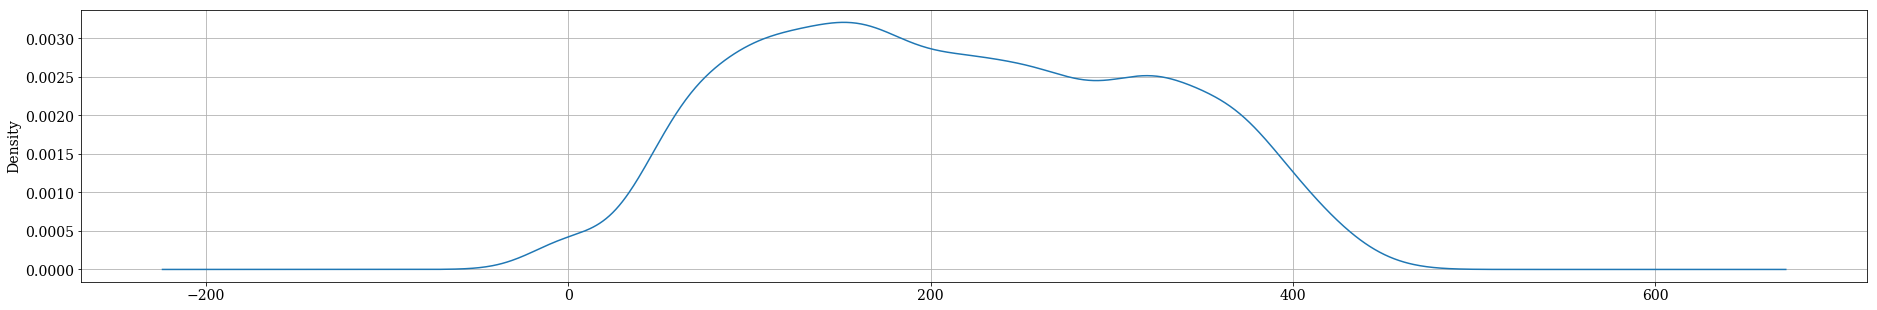

In [8]:
rcParams['figure.figsize'] = 32, 5
Series(reshape(dd2,(1,56*56))[0]).plot(kind='kde')
pyplot.grid(True)

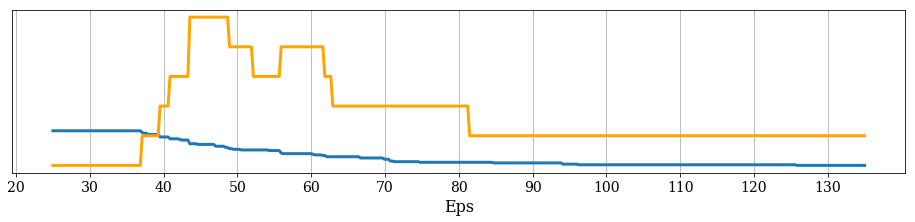

In [17]:
rcParams['figure.figsize'] = 16, 3

eps_list = linspace(25.0,135.0,num=410)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=3, metric='precomputed').fit(dd2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/48, linewidth=3)
plot(eps_list, n_clusters_list, color='Orange', linewidth=3)
pyplot.grid(True)
#pyplot.title("N. clusters (orange) and noise size (blue) vs. eps")
pyplot.xticks(np.arange(20, 140, 10))
plt.yticks([])
plt.xlabel('Eps', fontsize=16)

plt.savefig('Images/TimeSeries/DBSCAN_DTWSakoe_noise.png', format='png', bbox_inches='tight')

# DBSCAN

In [10]:
def YearsClusters(years_list, labels):
    years_cluster = []
    for ndx, year in enumerate(db.labels_):
        years_cluster.append([years_list[ndx],year])
    
    result = { x: [y[0] for y in years_cluster if y[1]==x] for x in set(labels)}
    return result

In [11]:
db = DBSCAN(eps=60, min_samples=3, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Numero Clusters e conteggio: %d' % n_clusters_)
print (itemfreq(db.labels_))


print('')
print('Suddivisione anni nei cluster:')
years_clusters_result = YearsClusters(years_list, db.labels_)
print(years_clusters_result)

Numero Clusters e conteggio: 4
[[-1 19]
 [ 0  3]
 [ 1 21]
 [ 2 10]
 [ 3  3]]

Suddivisione anni nei cluster:
{0: [1962, 1981, 2002], 1: [1963, 1965, 1967, 1968, 1969, 1978, 1982, 1983, 1985, 1994, 1996, 1997, 1998, 1999, 2003, 2006, 2007, 2009, 2010, 2011, 2016], 2: [1964, 1973, 1974, 1979, 1986, 1987, 2008, 2013, 2014, 2015], 3: [1972, 1976, 1995], -1: [1966, 1970, 1971, 1975, 1977, 1980, 1984, 1988, 1989, 1990, 1991, 1992, 1993, 2000, 2001, 2004, 2005, 2012, 2017]}


# Visualizzazione tramite Multidimensional Scaling

('Stress value: ', 1632121.7290596738)


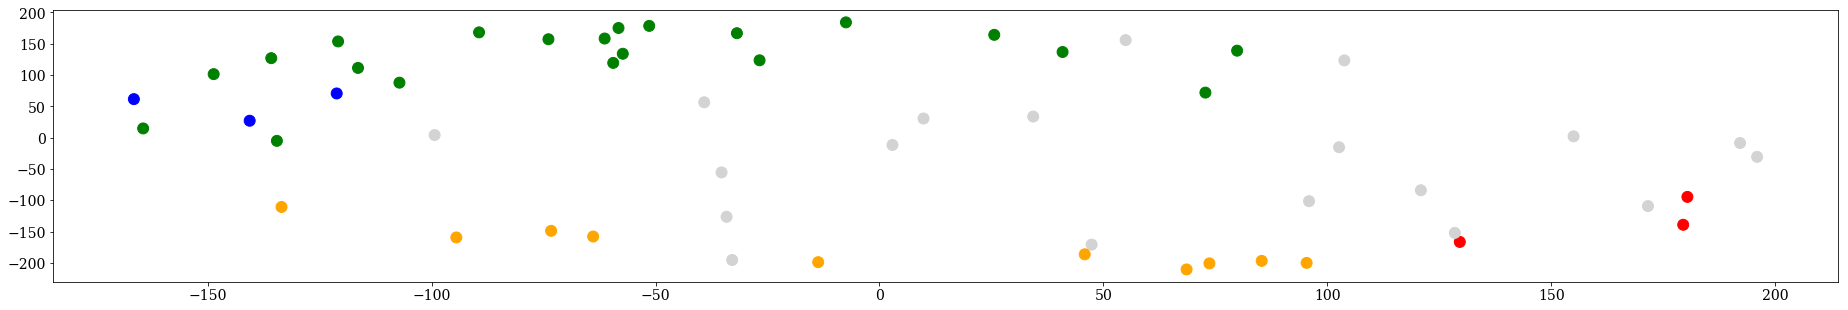

In [12]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print ("Stress value: ", pos.stress_)

cols = ['lightgray', 'red', 'green', 'orange', 'blue', 'black']
cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

# Visualizzazione tramite Serie Colorate

In [25]:
rcParams['figure.figsize'] = 9,4

def PrintSeries(series, cluster, color, name): #poco utile
    for i in cluster:
        plt.plot(series.get_group(str(i)+'-12-31 00:00:00').values, color)
    plt.show()

def PrintSeriesMod(series, years_list, cluster, color, name):
    for i in cluster:
        plt.plot(series[years_list.index(i)], color)
        plt.xlabel('numero di giorni', fontsize=16)
        plt.ylabel ('valore di Open', fontsize=16)
    #plt.show()

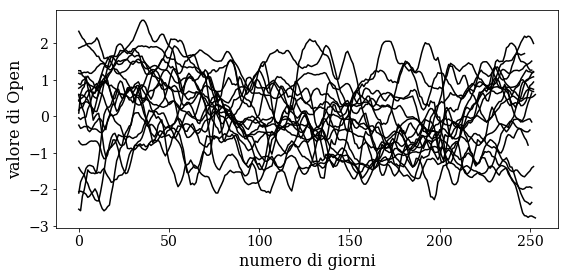

In [26]:
PrintSeriesMod(mod_series, years_list, years_clusters_result[-1], 'Black', 'Noise')
plt.savefig('Images/TimeSeries/DBScanSakoenoise.png', format='png', bbox_inches='tight')

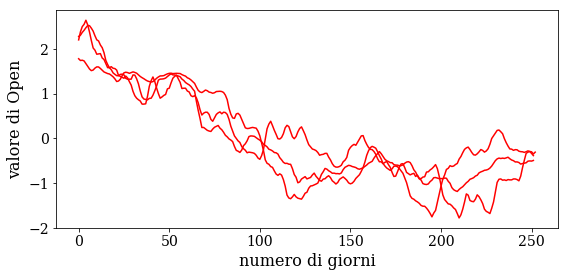

In [27]:
PrintSeriesMod(mod_series, years_list, years_clusters_result[0], 'Red', 'Cluster 1')
plt.savefig('Images/TimeSeries/DBScanSakoec1.png', format='png', bbox_inches='tight')

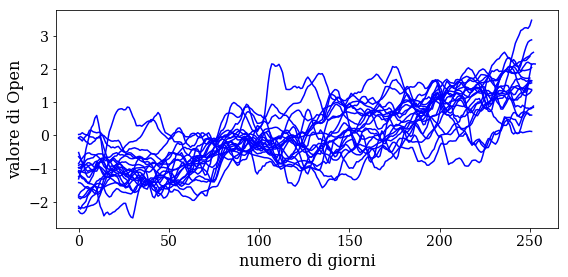

In [28]:
PrintSeriesMod(mod_series, years_list, years_clusters_result[1], 'Blue', 'Cluster 2')
plt.savefig('Images/TimeSeries/DBScanSakoec2.png', format='png', bbox_inches='tight')

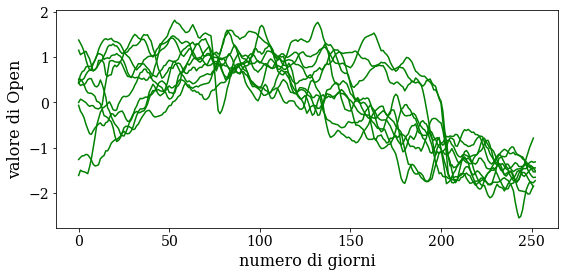

In [29]:
PrintSeriesMod(mod_series, years_list, years_clusters_result[2], 'Green', 'Cluster 3')
plt.savefig('Images/TimeSeries/DBScanSakoec3.png', format='png', bbox_inches='tight')

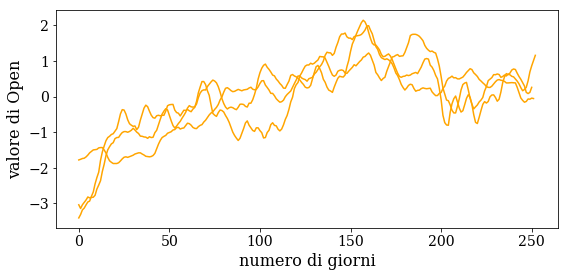

In [30]:
PrintSeriesMod(mod_series, years_list, years_clusters_result[3], 'Orange', 'Cluster 4')
plt.savefig('Images/TimeSeries/DBScanSakoec4.png', format='png', bbox_inches='tight')